In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('BlackFriday.csv')

In [3]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Dealing with NA values

In [4]:
df.isna().any()

User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

In [5]:
df.fillna(value=0,inplace=True)

In [6]:
df["Product_Category_2"] = df["Product_Category_2"].astype(int)
df["Product_Category_3"] = df["Product_Category_3"].astype(int)

## Exploring the data

### Gender & Age

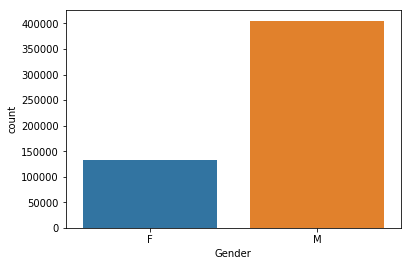

In [7]:
sns.countplot(df['Gender'])

To conclude the graph above, we can see that the most of transactions were done by Males

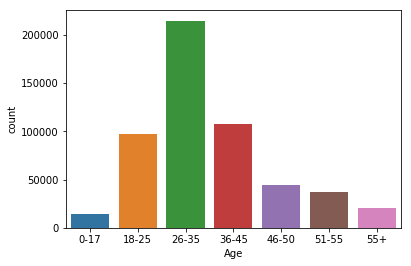

In [8]:
sns.countplot(df['Age'], order=df['Age'].value_counts().index.sort_values())

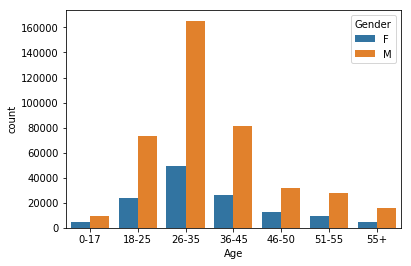

In [9]:
sns.countplot(df['Age'],hue=df['Gender'], order=df['Age'].value_counts().index.sort_values())

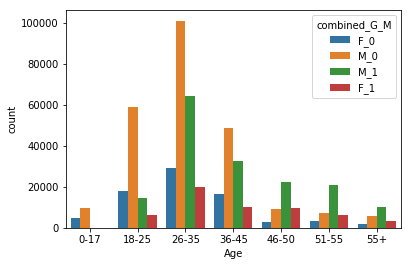

In [10]:
df['combined_G_M'] = df.apply(lambda x:'%s_%s' % (x['Gender'],x['Marital_Status']),axis=1)
sns.countplot(df['Age'],
              hue=df['combined_G_M'],
              order=df['Age'].value_counts().index.sort_values())

#### Conclusions: 

 - From the plots above we can see that the greatest amount of transactions were done by unmarried males in the age of 26-35

 - After the age 45, the majority of transactions is done by married males. One may conclude that the data reflects that ladies do shop, but their spouses are making transactions
 - The data is distributed normally which does make sense

### City

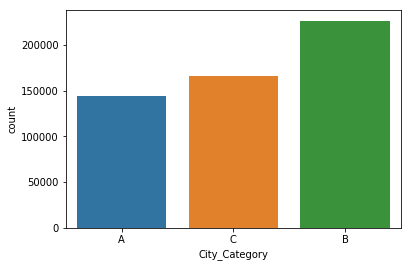

In [11]:
sns.countplot(df['City_Category'])

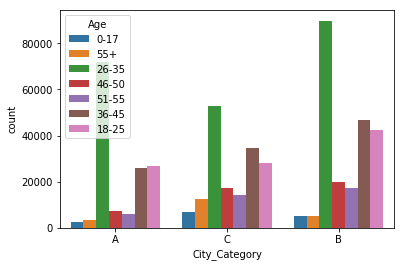

In [12]:
sns.countplot(df['City_Category'],hue=df['Age'])

### Purchase analysis

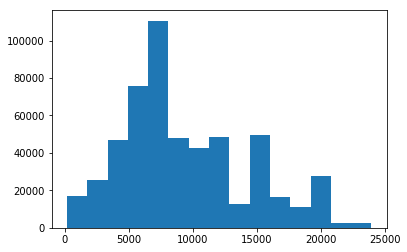

In [13]:
plt.hist(df['Purchase'],bins=15, alpha=1)
plt.show()

We can see that is is skewed to the right, but resembles normal distribution

Let's see the most popular products

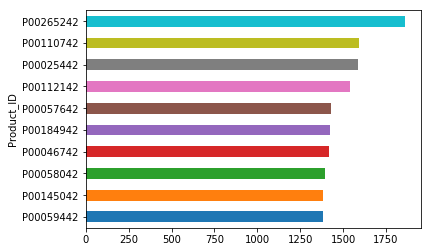

In [14]:
df.groupby('Product_ID')['Purchase'].count().nlargest(10).sort_values().plot('barh')

In [15]:
df.groupby('Product_ID').count()['User_ID'].describe()

count    3623.000000
mean      148.378968
std       208.176730
min         1.000000
25%        19.000000
50%        70.000000
75%       192.000000
max      1858.000000
Name: User_ID, dtype: float64

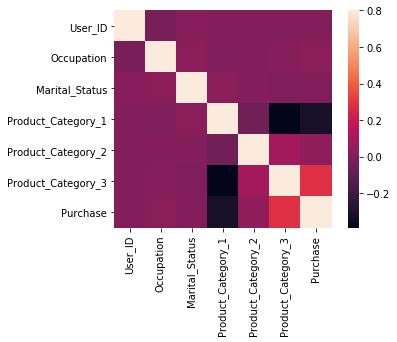

In [16]:
sns.heatmap(df.corr(), vmax=.8, square=True)

In [17]:
len(df.User_ID.unique())

5891

## Model creation

For this project I tried using Random Forest model for predictions.

Let's try to create a model for the existing customers.

### Feature engineering

First, let's deal with the categorical features. For this project, we'll create dummy data for IDs(Product_ID and User_ID) as well as with other categorical features.

In [18]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
0,1000001,P00069042,F,0-17,10,A,2,0,3,0,0,8370,F_0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200,F_0
2,1000001,P00087842,F,0-17,10,A,2,0,12,0,0,1422,F_0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14,0,1057,F_0
4,1000002,P00285442,M,55+,16,C,4+,0,8,0,0,7969,M_0


In [19]:
df['User_ID'] = LabelEncoder().fit_transform(df['User_ID'])
df['Product_ID'] = LabelEncoder().fit_transform(df['Product_ID'])
df['Gender'] = np.where(df['Gender']=='M',1,0)
df_Age = pd.get_dummies(df.Age)
df_CC = pd.get_dummies(df.City_Category)
df_SIC = pd.get_dummies(df.Stay_In_Current_City_Years)
df_encoded = pd.concat([df,df_Age,df_CC,df_SIC],axis=1)
df_encoded.drop(['Age','City_Category','Stay_In_Current_City_Years', 'combined_G_M'],axis=1,inplace=True)

### Splitting data

In [20]:
df_frac = df_encoded.sample(frac=0.02,random_state=100)
X = df_frac.drop(['Purchase'], axis=1)
y = df_frac['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

In [21]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=3,scoring='neg_mean_absolute_error').fit(X_train,y_train)

### Finding best parameters

Best parameter: {'n_estimators': 300}
Best score: 2216.25


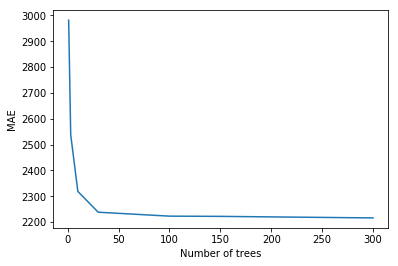

In [22]:
plt.figure()
plt.plot(list(param_grid.values())[0],(abs(grid_rf.cv_results_['mean_test_score'])))
plt.xlabel('Number of trees')
plt.ylabel('MAE')
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format(abs(grid_rf.best_score_)))

In [23]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300],'max_depth':[1,3,5,7,9]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=3,scoring='neg_mean_absolute_error').fit(X_train,y_train)

In [24]:
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format(abs(grid_rf.best_score_)))

Best parameter: {'max_depth': 9, 'n_estimators': 300}
Best score: 2219.89


### Learning curve

In [25]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=9, n_estimators=300), X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

In [26]:
train_scores_mean = np.mean(abs(train_scores), axis=1)
train_scores_std = np.std(abs(train_scores), axis=1)
valid_scores_mean = np.mean(abs(valid_scores), axis=1)
valid_scores_std = np.std(abs(valid_scores), axis=1)

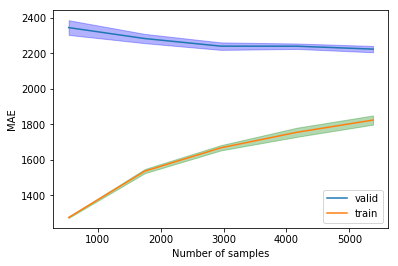

In [27]:
plt.figure()
plt.plot(train_sizes,valid_scores_mean,label='valid')
plt.plot(train_sizes,train_scores_mean,label='train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3,color="g")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,valid_scores_mean + valid_scores_std, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.legend()

## Using the whole dataset for building a model

In [ ]:
X = df_encoded.drop(['Purchase'], axis=1)
y = df_encoded['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

rf = RandomForestRegressor(max_depth=9, n_estimators=50).fit(X_train,y_train)
y_predicted = rf.predict(X_test)
print('Test set MAE: {:.3f}'.format(mean_absolute_error(y_test,y_predicted)))